In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys
import re

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests11 as vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 700
trials =1000
skip_boot=False
skip_shi=False
linspace= 40
smoothing =5
adapt_c= True
data_tuned_epsilon = True


In [4]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'SW Test','Shi (2015)', 'Naive Bootstrap','Pairwise Bootstrap',
                  'Optimal SW Test','Optimal Pairwise Bootstrap']


    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs_0928/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    plt.plot(params_new, interp(1-results2[:,2,0]) ,label='SW Test')
    
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,5,0]),label='Pairwise Bootstrap')
        
    if data_tuned_epsilon:
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Optimal SW Test')
        plt.plot(params_new,interp(1-results2[:,7,0]),label='Optimal Pairwise Bootstrap')
        


    plt.legend()
    plt.savefig('paper_figs_0928/'+name,dpi=300)
    plt.show()


In [5]:
def keep_alphanumeric(string):
    return re.sub(r'[^a-zA-Z0-9_]', '', string)


def mc_run_size(nobs,epsilon,data_tuned_epsilon=None,alpha=.05):
    betas = np.linspace(0,3,linspace)
    results = []
    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
        gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,
                                              epsilon=epsilon,data_tuned_epsilon=data_tuned_epsilon,alpha=alpha)
        reg,twostep, sw, boot1,boot2,sw_test_opt,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,sw,shi,boot1,boot2,sw_test_opt,boot3])

        print(beta,boot2)

    name = keep_alphanumeric('size_c1%s_alpha%s_datac%s_nobs%s_trials%s'%(epsilon,alpha,data_tuned_epsilon,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

In [6]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

def mc_run_power(nobs,epsilon,data_tuned_epsilon=None,alpha=.05):
    betas = np.linspace(0,3,linspace)
    results = []
    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
        gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,
                                              epsilon=epsilon,data_tuned_epsilon=data_tuned_epsilon,alpha=alpha)
        reg,twostep, sw, boot1,boot2,sw_test_opt,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,sw,shi,boot1,boot2,sw_test_opt,boot3])

    name = keep_alphanumeric('power_c1%s_alpha%s_datac%s_nobs%s_trials%s'%(epsilon,alpha,data_tuned_epsilon,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

# Size stuff, alpha=.05,n=200

0.0 [0.95142857 0.02714286 0.02142857]
0.07692307692307693 [0.96       0.02857143 0.01142857]
0.15384615384615385 [0.96857143 0.02142857 0.01      ]
0.23076923076923078 [0.97       0.01714286 0.01285714]
0.3076923076923077 [0.97714286 0.01285714 0.01      ]
0.38461538461538464 [0.96714286 0.01571429 0.01714286]
0.46153846153846156 [0.96428571 0.02142857 0.01428571]
0.5384615384615385 [0.97285714 0.01714286 0.01      ]
0.6153846153846154 [0.96 0.02 0.02]
0.6923076923076923 [0.96714286 0.01571429 0.01714286]
0.7692307692307693 [0.95571429 0.02142857 0.02285714]
0.8461538461538463 [0.96285714 0.01571429 0.02142857]
0.9230769230769231 [0.96285714 0.01714286 0.02      ]
1.0 [0.97       0.01571429 0.01428571]
1.076923076923077 [0.96285714 0.01571429 0.02142857]
1.153846153846154 [0.96857143 0.01       0.02142857]
1.2307692307692308 [0.96428571 0.00857143 0.02714286]
1.3076923076923077 [0.96857143 0.01142857 0.02      ]
1.3846153846153846 [0.97857143 0.00571429 0.01571429]
1.4615384615384617 

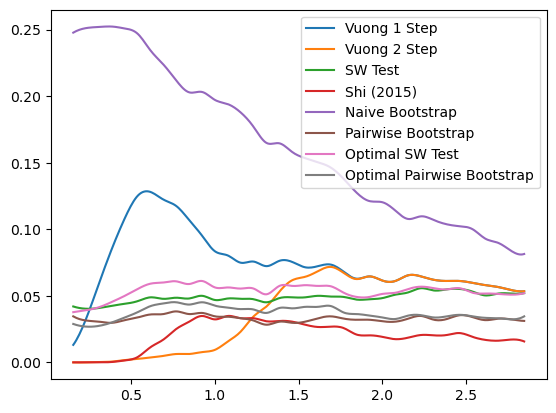

In [7]:
epsilon=.5
nobs = 200
alpha=.05

mc_run_size(nobs,epsilon,data_tuned_epsilon=data_tuned_epsilon,alpha=alpha)

# Power stuff, alpha=.05,n=200

--------saving fig------------
power_c105_alpha005_datacTrue_nobs200_trials1000.png
--------------------


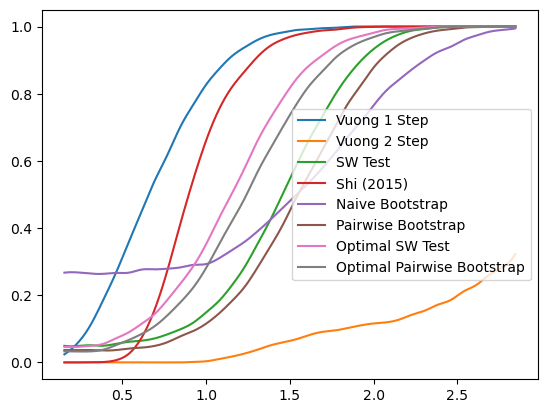

In [8]:
nobs = 200
alpha=.05

mc_run_power(nobs,epsilon,data_tuned_epsilon=data_tuned_epsilon,alpha=alpha)

# extra size sims, alpha=.01,n=100 + n=200, alpha =.01

0.0 [0.98285714 0.00714286 0.01      ]
0.07692307692307693 [0.98285714 0.00714286 0.01      ]
0.15384615384615385 [0.98714286 0.01285714 0.        ]
0.23076923076923078 [0.98714286 0.00857143 0.00428571]
0.3076923076923077 [0.99       0.00428571 0.00571429]
0.38461538461538464 [0.99714286 0.00142857 0.00142857]
0.46153846153846156 [0.98571429 0.00571429 0.00857143]
0.5384615384615385 [0.99285714 0.00142857 0.00571429]
0.6153846153846154 [0.98285714 0.00571429 0.01142857]
0.6923076923076923 [0.99142857 0.00285714 0.00571429]
0.7692307692307693 [0.99       0.00285714 0.00714286]
0.8461538461538463 [0.98571429 0.00428571 0.01      ]
0.9230769230769231 [0.98142857 0.00285714 0.01571429]
1.0 [0.98857143 0.00142857 0.01      ]
1.076923076923077 [0.98857143 0.00142857 0.01      ]
1.153846153846154 [0.98571429 0.         0.01428571]
1.2307692307692308 [0.98714286 0.         0.01285714]
1.3076923076923077 [0.98285714 0.00285714 0.01428571]
1.3846153846153846 [0.98857143 0.00142857 0.01      ]
1

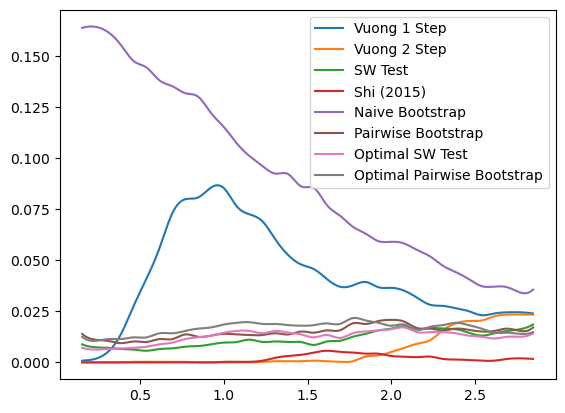

In [9]:
nobs =100
alpha=.01

mc_run_size(nobs,epsilon,data_tuned_epsilon=data_tuned_epsilon,alpha=alpha)

0.0 [0.97857143 0.01142857 0.01      ]
0.07692307692307693 [0.98285714 0.01       0.00714286]
0.15384615384615385 [0.98714286 0.00571429 0.00714286]
0.23076923076923078 [0.99285714 0.00285714 0.00428571]
0.3076923076923077 [0.98428571 0.01142857 0.00428571]
0.38461538461538464 [0.98857143 0.         0.01142857]
0.46153846153846156 [0.98857143 0.00285714 0.00857143]
0.5384615384615385 [0.99       0.00428571 0.00571429]
0.6153846153846154 [0.99       0.00571429 0.00428571]
0.6923076923076923 [0.99285714 0.00571429 0.00142857]
0.7692307692307693 [0.99142857 0.00571429 0.00285714]
0.8461538461538463 [0.99142857 0.00142857 0.00714286]
0.9230769230769231 [0.98714286 0.00428571 0.00857143]
1.0 [0.99142857 0.00285714 0.00571429]
1.076923076923077 [0.98857143 0.00142857 0.01      ]
1.153846153846154 [0.99       0.00142857 0.00857143]
1.2307692307692308 [0.99428571 0.         0.00571429]
1.3076923076923077 [0.98428571 0.00142857 0.01428571]
1.3846153846153846 [0.99142857 0.         0.00857143]
1

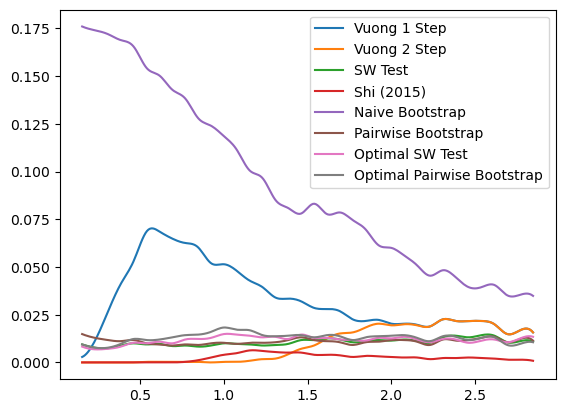

In [10]:
nobs = 200
alpha=.01

mc_run_size(nobs,epsilon,data_tuned_epsilon=data_tuned_epsilon,alpha=alpha)

# Extra Power Sims , alpha=.01,n=100 + n=200, alpha =.01

--------saving fig------------
power_c105_alpha001_datacTrue_nobs100_trials1000.png
--------------------


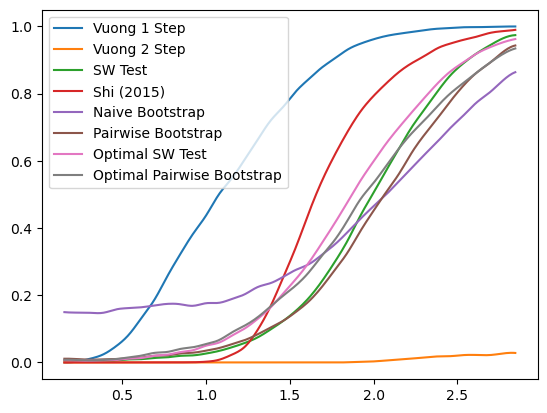

In [11]:
nobs = 100
alpha=.01
mc_run_power(nobs,epsilon,data_tuned_epsilon=data_tuned_epsilon,alpha=alpha)

--------saving fig------------
power_c105_alpha001_datacTrue_nobs200_trials1000.png
--------------------


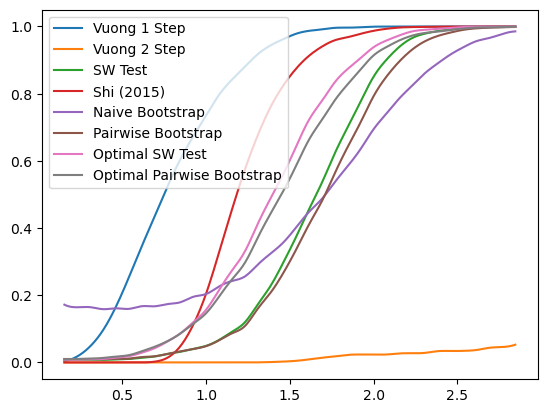

In [12]:
nobs = 200
alpha=.01
mc_run_power(nobs,epsilon,data_tuned_epsilon=data_tuned_epsilon,alpha=alpha)